In [8]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

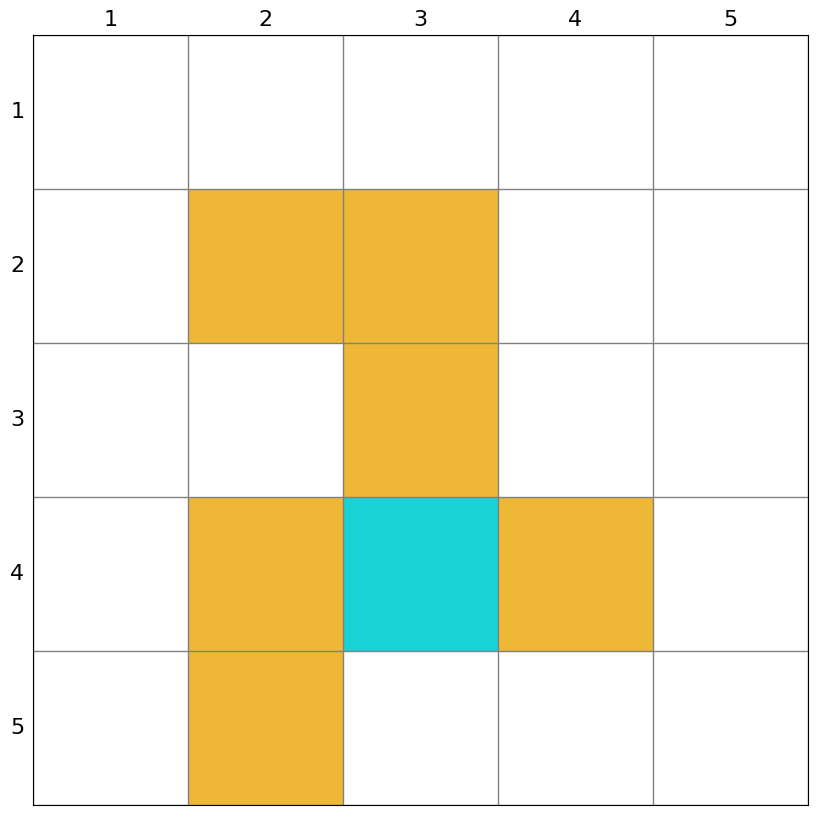

In [9]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [10]:
def MC_exploring_starts_first_visit(env, theta=0.0001, gamma=0.8, length=100, epochs=5):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    # 初始化：对策略 π_0 进行初始猜测
    qvalue = np.zeros((state_space_size, action_space_size))  # 初始化Q值表
    all_returns = {}  # 存储每个状态-动作对的所有回报
    policy = np.ones(shape=(state_space_size, action_space_size)) / action_space_size  # 初始化为均匀随机策略 π_0

    # 初始化 all_returns 字典
    for state in range(state_space_size):
        for action in range(action_space_size):
            all_returns[(state, action)] = []  # 每个状态-动作对对应一个空列表

    # 目标：寻找最优策略
    for _ in range(epochs):
        env.reset()
        for state in range(state_space_size):
            for action in range(action_space_size):
                # 生成一个episode：随机选择一个起始状态-动作对 (s_0, a_0)
                env.agent_location = env.state2pos(state)  # 设置代理位置
                episode = []  # 初始化episode序列
                next_action = action
                next_state = state
                episode_length = length  # 设定episode长度

                # 生成一条episode (s_0, a_0, r_1, ..., s_T−1, a_T−1, r_T)
                while episode_length > 0:
                    episode_length -= 1
                    state = next_state
                    action = next_action
                    _, reward, done, _, _ = env.step(action)  # 执行动作并获取奖励

                    next_state = env.pos2state(env.agent_location)  # 更新状态
                    next_action = np.random.choice(np.arange(len(policy[next_state])), p=policy[next_state])  # 按照策略选择下一个动作

                    # 将该状态-动作对以及对应的奖励加入episode
                    episode.append({
                        "state": state, 
                        "action": action, 
                        "reward": reward, 
                        "next_state": next_state, 
                        "next_action": next_action
                    })

                    if done:  # 如果到达终止状态，结束本次episode
                        break
                
                # 策略评估与改进
                g = 0
                # 逆向遍历整个episode，计算累积回报g
                for step in range(len(episode) - 1, -1, -1):
                    g = episode[step]['reward'] + gamma * g  # 更新回报
                    s = episode[step]['state']
                    a = episode[step]['action']

                    # 采用首次访问策略
                    if (s, a) not in [(ep['state'], ep['action']) for ep in episode[:step]]:
                        all_returns[(s, a)].append(g)  # 将该回报添加到该状态-动作对的所有回报中
                        qvalue[s][a] = np.mean(all_returns[(s, a)])  # 更新Q值为回报的平均值

        # 根据Q值最大化更新策略 π，使其贪婪
        for s in range(state_space_size):
            qvalue_star = qvalue[s].max()  # 找到最大的Q值
            action_star = np.argmax(qvalue[s])  # 找到对应的动作
            policy[s] = np.zeros(shape=action_space_size)  # 将策略初始化为0
            policy[s, action_star] = 1  # 对应最大Q值的动作设置为1（贪婪选择）

    return policy

In [11]:
def MC_exploring_starts(env, theta=0.001, gamma=0.8, length=100, epochs=5):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    # 初始化：对策略 π_0 进行初始猜测
    qvalue = np.zeros((state_space_size, action_space_size))  # 初始化Q值表
    all_returns = {}  # 存储每个状态-动作对的所有回报
    policy = np.ones(shape=(state_space_size, action_space_size)) / action_space_size  # 初始化为均匀随机策略 π_0

    # 初始化 all_returns 字典
    for state in range(state_space_size):
        for action in range(action_space_size):
            all_returns[(state, action)] = []  # 每个状态-动作对对应一个空列表

    # 目标：寻找最优策略
    for epoch in range(epochs):
        for state in range(state_space_size):
            for action in range(action_space_size):
                # 生成一个episode：随机选择一个起始状态-动作对 (s_0, a_0)
                env.agent_location = env.state2pos(state)  # 设置代理位置
                episode = []  # 初始化episode序列
                next_action = action
                next_state = state
                episode_length = length  # 设定episode长度

                # 生成一条episode (s_0, a_0, r_1, ..., s_T−1, a_T−1, r_T)
                while episode_length > 0:
                    episode_length -= 1
                    state = next_state
                    action = next_action
                    _, reward, done, _, _ = env.step(action)  # 执行动作并获取奖励

                    next_state = env.pos2state(env.agent_location)  # 更新状态
                    next_action = np.random.choice(np.arange(len(policy[next_state])), p=policy[next_state])  # 按照策略选择下一个动作

                    # 将该状态-动作对以及对应的奖励加入episode
                    episode.append({
                        "state": state, 
                        "action": action, 
                        "reward": reward, 
                        "next_state": next_state, 
                        "next_action": next_action
                    })

                    if done:  # 如果到达终止状态，结束本次episode
                        break
                
                # 策略评估与改进
                g = 0
                # 逆向遍历整个episode，计算累积回报g
                for step in range(len(episode) - 1, -1, -1):
                    g = episode[step]['reward'] + gamma * g  # 更新回报
                    s = episode[step]['state']
                    a = episode[step]['action']

                    # 采用every-visit策略，无需判断是否是首次访问
                    all_returns[(s, a)].append(g)  # 将该回报添加到该状态-动作对的所有回报中
                    qvalue[s][a] = np.mean(all_returns[(s, a)])  # 更新Q值为回报的平均值

        # 根据Q值最大化更新策略 π，使其贪婪
        for s in range(state_space_size):
            qvalue_star = qvalue[s].max()  # 找到最大的Q值
            action_star = np.argmax(qvalue[s])  # 找到对应的动作
            policy[s] = np.zeros(shape=action_space_size)  # 将策略初始化为0
            policy[s, action_star] = 1  # 对应最大Q值的动作设置为1（贪婪选择）

    return policy


In [12]:
def mc_exploring_starts1(env, theta=0.001, gamma=0.8, length=100):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size

    qvalue = np.zeros((state_space_size, action_space_size))
    returns = { (state, action): [] for state in range(state_space_size) for action in range(action_space_size) }
    policy = np.ones((state_space_size, action_space_size)) / action_space_size

    policy_change_threshold = theta

    while True:
        old_policy = policy.copy()

        for state in range(state_space_size):
            for action in range(action_space_size):
                env.agent_location = env.state2pos(state)
                episode = []
                next_state, next_action = state, action
                episode_length = length

                while episode_length > 0:
                    episode_length -= 1
                    state = next_state
                    action = next_action
                    _, reward, done, _, _ = env.step(action)
                    next_state = env.pos2state(env.agent_location)
                    next_action = np.random.choice(np.arange(action_space_size), p=policy[next_state])

                    episode.append({
                        'state': state,
                        'action': action,
                        'reward': reward,
                        'next_state': next_state
                    })

                    if done:
                        break

                g = 0
                visited = set()

                for step in reversed(range(len(episode))):
                    reward = episode[step]['reward']
                    state = episode[step]['state']
                    action = episode[step]['action']
                    g = reward + gamma * g

                    if (state, action) not in visited:
                        visited.add((state, action))
                        returns[(state, action)].append(g)
                        qvalue[state, action] = np.mean(returns[(state, action)])

        for state in range(state_space_size):
            best_action = np.argmax(qvalue[state])
            policy[state] = np.zeros(action_space_size)
            policy[state, best_action] = 1

        policy_diff = np.linalg.norm(old_policy - policy, ord=1)
        if policy_diff < policy_change_threshold:
            break

    return policy


In [13]:
policy = MC_exploring_starts_first_visit(env)
print(policy)

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


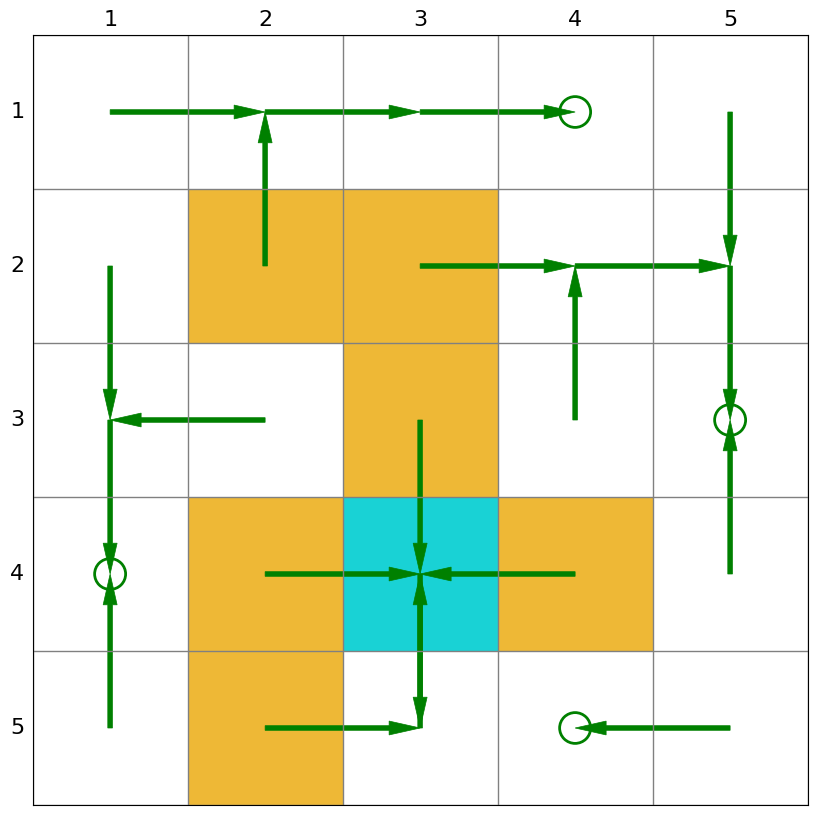

In [14]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()